<a href="https://colab.research.google.com/github/Basma-DA/arabic-sign-language/blob/main/DA450_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lodaing Dataset

In [ ]:
#https://www.kaggle.com/datasets/muhammadalbrham/rgb-arabic-alphabets-sign-language-dataset

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aseelalzaben","key":"b18c7bdbf2ef382ff9ad2e819a62a8f7"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:



!kaggle datasets download -d muhammadalbrham/rgb-arabic-alphabets-sign-language-dataset


Dataset URL: https://www.kaggle.com/datasets/muhammadalbrham/rgb-arabic-alphabets-sign-language-dataset
License(s): CC-BY-SA-4.0
 99% 4.66G/4.72G [00:11<00:00, 353MB/s]
100% 4.72G/4.72G [00:11<00:00, 441MB/s]


In [ ]:
!unzip rgb-arabic-alphabets-sign-language-dataset.zip -d /content/arabic_sign_language

Streaming output truncated to the last 5000 lines.
  inflating: /content/arabic_sign_language/RGB ArSL dataset/Kaf/Kaf_140.jpg  
  inflating: /content/arabic_sign_language/RGB ArSL dataset/Kaf/Kaf_141.jpg  
  inflating: /content/arabic_sign_language/RGB ArSL dataset/Kaf/Kaf_142.jpeg  
  inflating: /content/arabic_sign_language/RGB ArSL dataset/Kaf/Kaf_143.jpg  
  inflating: /content/arabic_sign_language/RGB ArSL dataset/Kaf/Kaf_144.jpg  
  inflating: /content/arabic_sign_language/RGB ArSL dataset/Kaf/Kaf_145.jpeg  
  inflating: /content/arabic_sign_language/RGB ArSL dataset/Kaf/Kaf_146.jpeg  
  inflating: /content/arabic_sign_language/RGB ArSL dataset/Kaf/Kaf_147.jpg  
  inflating: /content/arabic_sign_language/RGB ArSL dataset/Kaf/Kaf_148.jpg  
  inflating: /content/arabic_sign_language/RGB ArSL dataset/Kaf/Kaf_149.jpg  
  inflating: /content/arabic_sign_language/RGB ArSL dataset/Kaf/Kaf_15.jpeg  
  inflating: /content/arabic_sign_language/RGB ArSL dataset/Kaf/Kaf_150.jpeg  
  inflati

In [ ]:
import os

data_path = '/content/arabic_sign_language'
print(os.listdir(data_path))


['RGB ArSL dataset']


## Importing Libraries

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image, ImageFile
import random
from collections import Counter
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical



## Data Visulization and Exploration

In [ ]:
data_path = '/content/arabic_sign_language/RGB ArSL dataset'
classes = os.listdir(data_path)
print("Number of classes:", len(classes))
print("Class names:", classes)


Number of classes: 31
Class names: ['Al', 'Teh', 'Meem', 'Heh', 'Beh', 'Kaf', 'Lam', 'Seen', 'Alef', 'Feh', 'Teh_Marbuta', 'Hah', 'Zain', 'Dal', 'Waw', 'Qaf', 'Jeem', 'Thal', 'Zah', 'Reh', 'Ghain', 'Yeh', 'Noon', 'Ain', 'Theh', 'Sheen', 'Dad', 'Laa', 'Tah', 'Khah', 'Sad']


In [ ]:

def count_total_images(base_path):
    total_images = 0
    # Loop through each label folder
    for label in os.listdir(base_path):
        label_folder_path = os.path.join(base_path, label)

        # Loop through each image file in the label folder
        for img_name in os.listdir(label_folder_path):
            img_path = os.path.join(label_folder_path, img_name)

            # Check if the item is an image (optional check based on file extension)
            if img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                total_images += 1

    print(f"Total number of images: {total_images}")
    return total_images

# Call the function to count total images
count_total_images(data_path)


Total number of images: 7856


7856

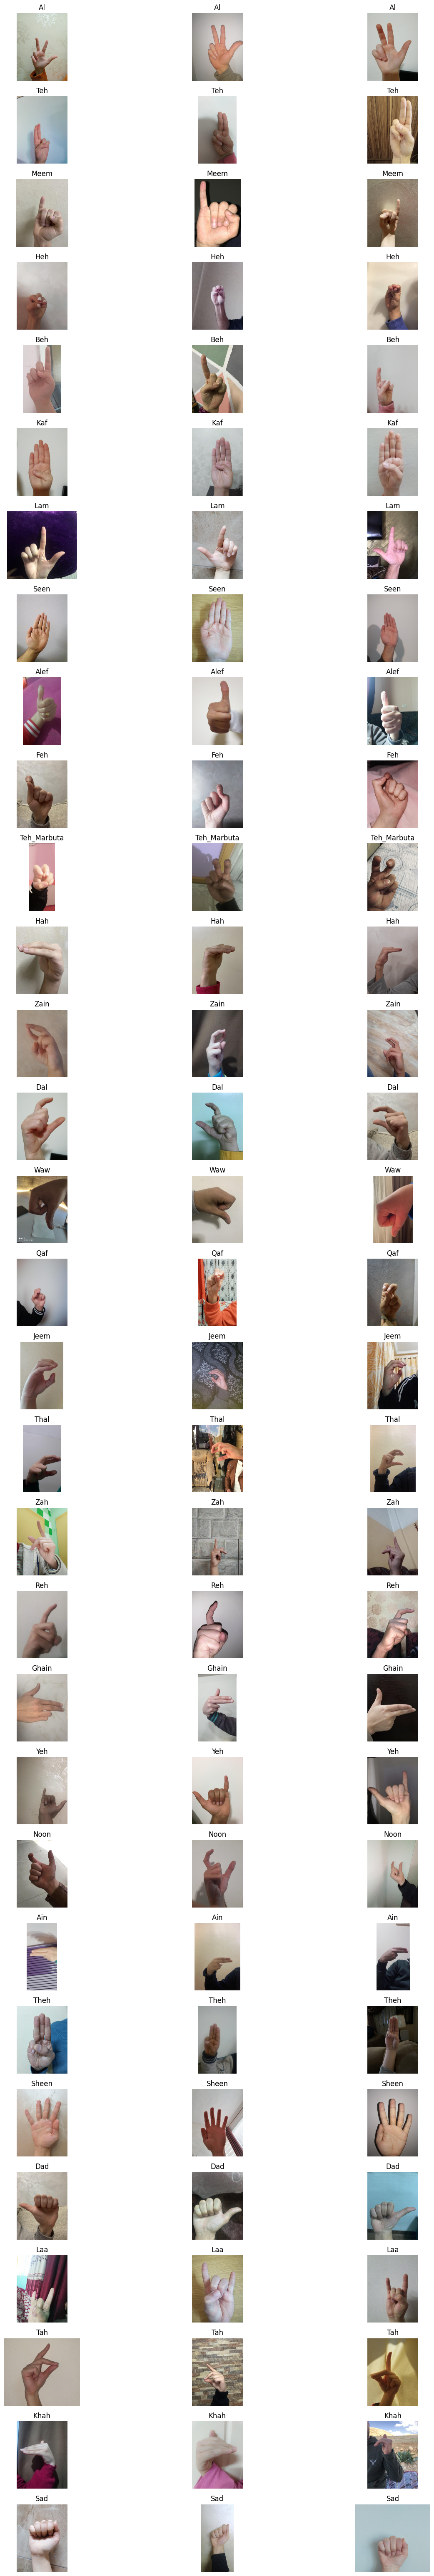

In [ ]:
def show_images_per_class(base_path, classes, images_per_class=5):
    plt.figure(figsize=(15, len(classes)*2))
    i = 1
    for label in classes:
        folder_path = os.path.join(base_path, label)
        images = os.listdir(folder_path)[:images_per_class]
        for img_name in images:
            img_path = os.path.join(folder_path, img_name)
            img = Image.open(img_path)
            plt.subplot(len(classes), images_per_class, i)
            plt.imshow(img)
            plt.axis('off')
            plt.title(label)
            i += 1
    plt.tight_layout()
    plt.show()

# Call the function
show_images_per_class(data_path, classes, images_per_class=3)


In [ ]:

image_sizes = []
image_formats = []

for label in classes:
    folder_path = os.path.join(data_path, label)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        try:
            with Image.open(img_path) as img:
                image_sizes.append(img.size)
                image_formats.append(img.format)
        except:
            continue

print("Most common image sizes:", Counter(image_sizes).most_common(5))
print("Image formats:", Counter(image_formats))


Most common image sizes: [((3024, 4032), 1484), ((3456, 4608), 535), ((3000, 4000), 413), ((2448, 3264), 402), ((3120, 4160), 353)]
Image formats: Counter({'JPEG': 7856})


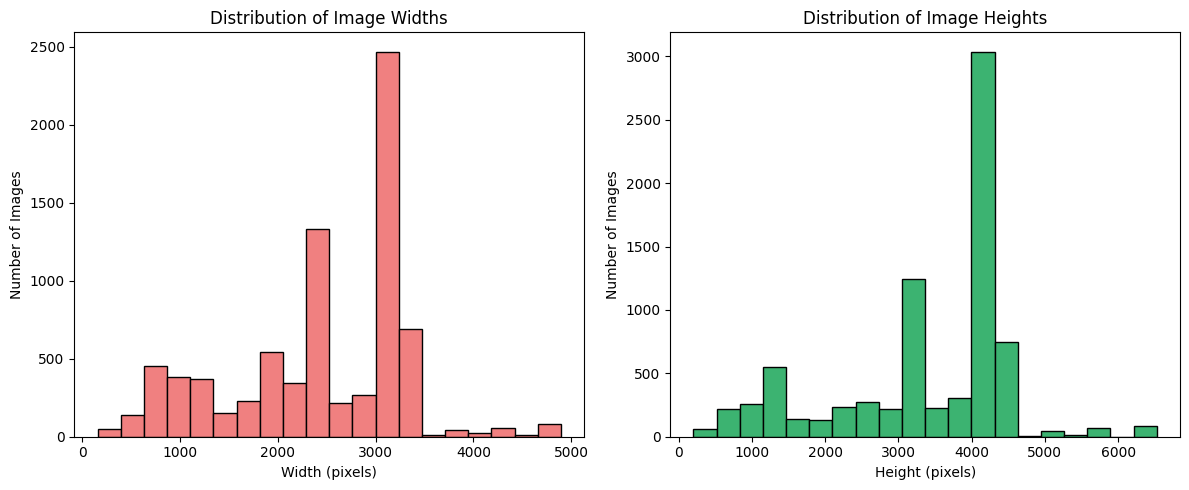

In [ ]:
#  Histogram of image widths and heights
widths = [size[0] for size in image_sizes]
heights = [size[1] for size in image_sizes]

plt.figure(figsize=(12, 5))

# Histogram of widths
plt.subplot(1, 2, 1)
plt.hist(widths, bins=20, color='lightcoral', edgecolor='black')
plt.title('Distribution of Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Number of Images')

# Histogram of heights
plt.subplot(1, 2, 2)
plt.hist(heights, bins=20, color='mediumseagreen', edgecolor='black')
plt.title('Distribution of Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Number of Images')

plt.tight_layout()
plt.show()


In [ ]:
# Count the number of images per class
images_per_class = {}
for label in classes:
    folder_path = os.path.join(data_path, label)
    images_per_class[label] = len(os.listdir(folder_path))
print("\n Number of images per class:")
for k, v in images_per_class.items():
    print(f"{k}: {v} images")


 Number of images per class:
Al: 276 images
Teh: 311 images
Meem: 253 images
Heh: 253 images
Beh: 307 images
Kaf: 264 images
Lam: 260 images
Seen: 266 images
Alef: 287 images
Feh: 255 images
Teh_Marbuta: 257 images
Hah: 246 images
Zain: 201 images
Dal: 235 images
Waw: 249 images
Qaf: 219 images
Jeem: 210 images
Thal: 202 images
Zah: 232 images
Reh: 227 images
Ghain: 230 images
Yeh: 272 images
Noon: 237 images
Ain: 244 images
Theh: 305 images
Sheen: 278 images
Dad: 266 images
Laa: 268 images
Tah: 226 images
Khah: 250 images
Sad: 270 images


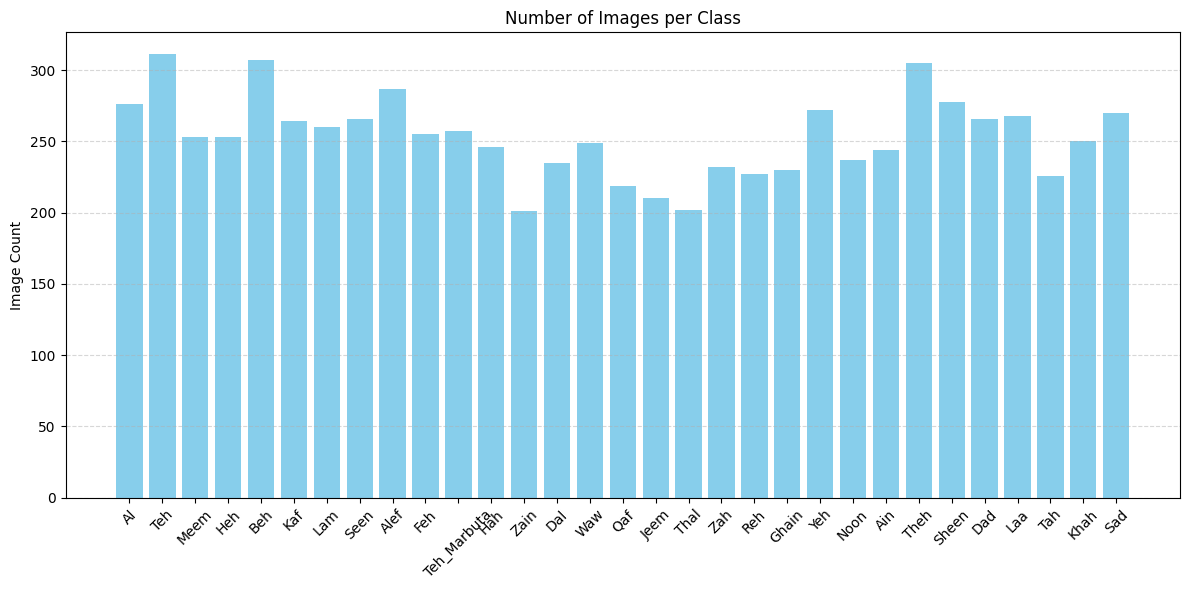

In [ ]:
#  Bar chart: Number of images per class
plt.figure(figsize=(12, 6))
plt.bar(images_per_class.keys(), images_per_class.values(), color='skyblue')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)
plt.ylabel('Image Count')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

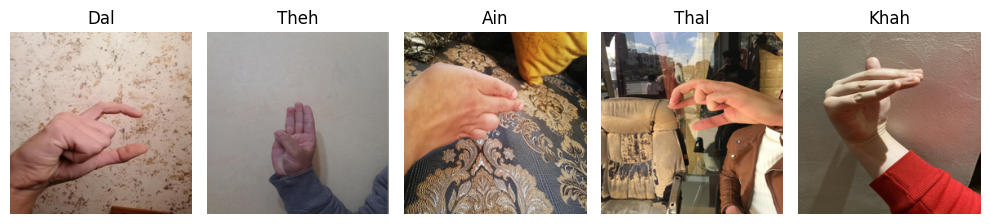

In [ ]:
target_size = (224,224)

def show_resized_sample_images(base_path, classes, samples=5):
    plt.figure(figsize=(10, 5))
    for i in range(samples):
        label = random.choice(classes)
        folder_path = os.path.join(base_path, label)
        image_name = random.choice(os.listdir(folder_path))
        image_path = os.path.join(folder_path, image_name)

        img = Image.open(image_path).convert('RGB')  # Ensure it's RGB
        img_resized = img.resize(target_size)

        plt.subplot(1, samples, i+1)
        plt.imshow(img_resized)
        plt.title(label)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_resized_sample_images(data_path, classes)

## Preprocessing

1. Loading the Images
2. Resizing the Images
3. Normalization
4. Encoding Labels
5. Data Splitting
6. Data Augmentation


In [ ]:
# Allow loading truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np

data = []
labels = []
categories = os.listdir(data_path)  # List of category names

target_size = (224, 224)    # Resize target

# Loop through all categories and images
for category in categories:
    category_path = os.path.join(data_path, category)

    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)

        try:
            # Load and resize the image
            img = load_img(img_path, target_size=target_size)
            img_array = img_to_array(img)
            data.append(img_array)
            labels.append(category)

        except Exception as e:
            print(f"Skipped corrupted image: {img_path} | Reason: {e}")

# Encode labels to numbers, then one-hot encode them
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels)

# Final shape info
print(f" Loaded {len(data)} images.")
print(f" Data shape: {np.array(data).shape}")
print(f" Labels shape: {categorical_labels.shape}")


 Loaded 7856 images.
 Data shape: (7856, 224, 224, 3)
 Labels shape: (7856, 31)


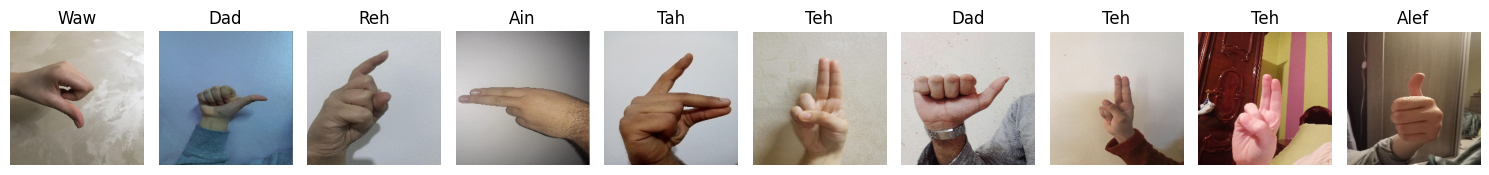

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_sample_images(data, labels, label_encoder, samples=10):
    plt.figure(figsize=(15, 4))
    indices = np.random.choice(len(data), samples, replace=False)  # Random indices

    for i, idx in enumerate(indices):
        img = data[idx]
        label = label_encoder.inverse_transform([np.argmax(labels[idx])])[0]  # Convert back to label name

        plt.subplot(1, samples, i + 1)
        plt.imshow(img / 255.0)  # Normalize image for display only
        plt.title(label)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function
show_sample_images(data, categorical_labels, label_encoder, samples=10)


Spliting dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, categorical_labels, test_size=0.2, random_state=42)
X_test,X_val,y_test,y_val=train_test_split(X_test,y_test,test_size=0.5, random_state=42)
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)
print(f'X_train shape is {X_train.shape}')
print(f'X_val shape is {X_val.shape}')
print(f'X_test shape is {X_test.shape}')
print(f'y_train shape is {y_train.shape}')
print(f'y_val shape is {y_val.shape}')
print(f'y_test shape is {y_test.shape}')

X_train shape is (6284, 224, 224, 3)
X_val shape is (786, 224, 224, 3)
X_test shape is (786, 224, 224, 3)
y_train shape is (6284, 31)
y_val shape is (786, 31)
y_test shape is (786, 31)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerator with augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values from [0, 255] to [0, 1]
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=False
)

# For validation and test: only normalization (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32)


In [ ]:
print("Number of training images:", len(X_train))
print("Number of validation images:", len(X_val))
print("Number of test images:", len(X_test))


Number of training images: 6284
Number of validation images: 786
Number of test images: 786


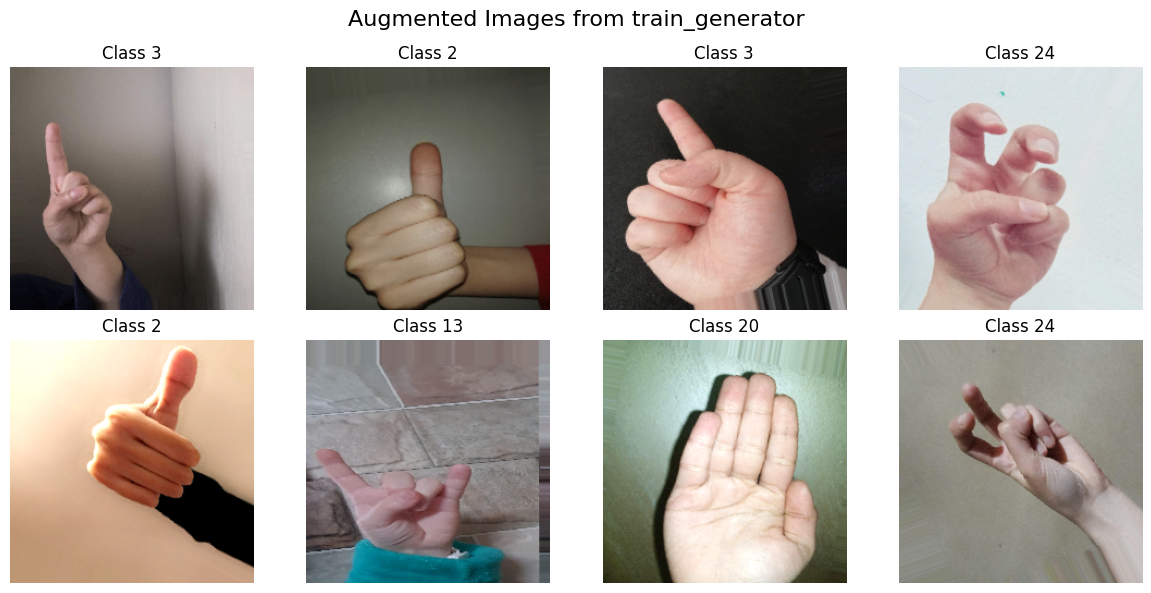

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Take one batch from the generator (batch size = 16)
images, labels = next(train_generator)

# Plot the first 8 augmented images
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i])
    plt.title(f"Class {np.argmax(labels[i])}")  # Shows the class index
    plt.axis('off')

plt.suptitle("Augmented Images from train_generator", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
print(images.dtype)
print(np.min(images), np.max(images))


float32
0.0 1.0


## Modeling

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming y_train contains one-hot encoded labels

# Convert one-hot encoded y_train back to class indices
y_train_indices = np.argmax(y_train, axis=1)

# Compute class weights using scikit-learn
class_weights = compute_class_weight(
    class_weight='balanced',              # Balances weights inversely proportional to class frequency
    classes=np.unique(y_train_indices),   # Unique class labels from the indices
    y=y_train_indices                     # Pass the class indices
)

# Convert to dictionary format required by model.fit
class_weights_dict = dict(enumerate(class_weights))

# Print for verification
print("Class weights:", class_weights_dict)

Class weights: {0: np.float64(1.034233048057933), 1: np.float64(0.956177723676202), 2: np.float64(0.8737486095661846), 3: np.float64(0.8140950900375696), 4: np.float64(0.965284178187404), 5: np.float64(1.0725379757637823), 6: np.float64(0.9699027627720327), 7: np.float64(1.061307211619659), 8: np.float64(1.050309209426709), 9: np.float64(1.0289831341084001), 10: np.float64(1.1854367100547067), 11: np.float64(1.0035132545512615), 12: np.float64(1.0448952444296642), 13: np.float64(0.9472414832680133), 14: np.float64(1.013548387096774), 15: np.float64(0.9792738039582359), 16: np.float64(1.13245629843215), 17: np.float64(1.1994655468600879), 18: np.float64(1.1199429691677063), 19: np.float64(0.9298609055933709), 20: np.float64(0.9214076246334311), 21: np.float64(0.9840275602881303), 22: np.float64(1.13245629843215), 23: np.float64(0.8446236559139785), 24: np.float64(0.9888276947285601), 25: np.float64(1.1785446361590397), 26: np.float64(0.7856964241060265), 27: np.float64(0.925614965385182

In [ ]:

# Number of target classes
num_classes = 31

# Load MobileNet base model without the top classification layers
base_model = MobileNet(
    weights='imagenet',           # Use pre-trained weights from ImageNet
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

# Build the final model
model = Model(inputs=base_model.input, outputs=output)




17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',  # Use sparse_categorical_crossentropy if labels are integers
    metrics=['accuracy']
)


In [ ]:
# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,896,031 (14.86 MB)

 Trainable params: 665,631 (2.54 MB)

 Non-trainable params: 3,230,400 (12.32 MB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Callbacks to save the best model and apply early stopping
checkpoint = ModelCheckpoint(
    'best_model.h5',           # File name to save best model
    monitor='val_loss',        # Monitor validation loss
    save_best_only=True,       # Save only when val_loss improves
    mode='min',                # Lower loss = better
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',        # Monitor validation loss
    patience=3,                # Stop if no improvement after 3 epochs
    restore_best_weights=True, # Restore the best weights
    verbose=1
)

In [ ]:

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    class_weight=class_weights_dict,
    callbacks=[checkpoint, early_stop]
)


# Save the entire model (architecture + weights + optimizer)
model.save("final_model.keras")
print(" Model saved successfully as: final_model.keras")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.0463 - loss: 4.6865
Epoch 1: val_loss improved from inf to 2.84142, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 94s 426ms/step - accuracy: 0.0464 - loss: 4.6851 - val_accuracy: 0.2163 - val_loss: 2.8414
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.1230 - loss: 3.7225
Epoch 2: val_loss improved from 2.84142 to 2.19431, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 392ms/step - accuracy: 0.1231 - loss: 3.7218 - val_accuracy: 0.3524 - val_loss: 2.1943
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.1972 - loss: 3.1517
Epoch 3: val_loss improved from 2.19431 to 1.78057, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 391ms/step - accuracy: 0.1973 - loss: 3.1509 - val_accuracy: 0.4898 - val_loss: 1.7806
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.2827 - loss: 2.6394
Epoch 4: val_loss improved from 1.78057 to 1.50859, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 389ms/step - accuracy: 0.2827 - loss: 2.6392 - val_accuracy: 0.5458 - val_loss: 1.5086
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.3440 - loss: 2.3120
Epoch 5: val_loss improved from 1.50859 to 1.32941, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 391ms/step - accuracy: 0.3440 - loss: 2.3119 - val_accuracy: 0.6158 - val_loss: 1.3294
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.3662 - loss: 2.1514
Epoch 6: val_loss improved from 1.32941 to 1.20271, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 393ms/step - accuracy: 0.3662 - loss: 2.1512 - val_accuracy: 0.6438 - val_loss: 1.2027
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.4196 - loss: 1.9628
Epoch 7: val_loss improved from 1.20271 to 1.08300, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 391ms/step - accuracy: 0.4196 - loss: 1.9627 - val_accuracy: 0.6718 - val_loss: 1.0830
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.4413 - loss: 1.8424
Epoch 8: val_loss improved from 1.08300 to 1.01673, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.4413 - loss: 1.8423 - val_accuracy: 0.7023 - val_loss: 1.0167
Epoch 9/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.4685 - loss: 1.7439
Epoch 9: val_loss improved from 1.01673 to 0.94272, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 76s 386ms/step - accuracy: 0.4686 - loss: 1.7437 - val_accuracy: 0.7137 - val_loss: 0.9427
Epoch 10/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.4853 - loss: 1.6332
Epoch 10: val_loss improved from 0.94272 to 0.88227, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 389ms/step - accuracy: 0.4853 - loss: 1.6331 - val_accuracy: 0.7379 - val_loss: 0.8823
Epoch 11/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.5171 - loss: 1.5329
Epoch 11: val_loss improved from 0.88227 to 0.84513, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 390ms/step - accuracy: 0.5171 - loss: 1.5330 - val_accuracy: 0.7481 - val_loss: 0.8451
Epoch 12/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.5058 - loss: 1.5358
Epoch 12: val_loss improved from 0.84513 to 0.80869, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 393ms/step - accuracy: 0.5059 - loss: 1.5356 - val_accuracy: 0.7506 - val_loss: 0.8087
Epoch 13/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.5443 - loss: 1.4368
Epoch 13: val_loss improved from 0.80869 to 0.76434, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 388ms/step - accuracy: 0.5443 - loss: 1.4367 - val_accuracy: 0.7621 - val_loss: 0.7643
Epoch 14/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.5654 - loss: 1.3354
Epoch 14: val_loss improved from 0.76434 to 0.75465, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 76s 387ms/step - accuracy: 0.5654 - loss: 1.3354 - val_accuracy: 0.7684 - val_loss: 0.7546
Epoch 15/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.5816 - loss: 1.2758
Epoch 15: val_loss improved from 0.75465 to 0.72654, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 393ms/step - accuracy: 0.5816 - loss: 1.2758 - val_accuracy: 0.7723 - val_loss: 0.7265
Epoch 16/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.5903 - loss: 1.2650
Epoch 16: val_loss improved from 0.72654 to 0.70719, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 391ms/step - accuracy: 0.5903 - loss: 1.2650 - val_accuracy: 0.7812 - val_loss: 0.7072
Epoch 17/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.6076 - loss: 1.2197
Epoch 17: val_loss improved from 0.70719 to 0.69262, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 393ms/step - accuracy: 0.6076 - loss: 1.2195 - val_accuracy: 0.7837 - val_loss: 0.6926
Epoch 18/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.6062 - loss: 1.2177
Epoch 18: val_loss improved from 0.69262 to 0.68073, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 392ms/step - accuracy: 0.6062 - loss: 1.2175 - val_accuracy: 0.7926 - val_loss: 0.6807
Epoch 19/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.6386 - loss: 1.1382
Epoch 19: val_loss improved from 0.68073 to 0.66039, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 391ms/step - accuracy: 0.6385 - loss: 1.1381 - val_accuracy: 0.7901 - val_loss: 0.6604
Epoch 20/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.6290 - loss: 1.1421
Epoch 20: val_loss improved from 0.66039 to 0.64851, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 393ms/step - accuracy: 0.6291 - loss: 1.1420 - val_accuracy: 0.7913 - val_loss: 0.6485
Epoch 21/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.6505 - loss: 1.0984
Epoch 21: val_loss improved from 0.64851 to 0.62764, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 76s 387ms/step - accuracy: 0.6505 - loss: 1.0984 - val_accuracy: 0.7913 - val_loss: 0.6276
Epoch 22/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.6547 - loss: 1.0783
Epoch 22: val_loss improved from 0.62764 to 0.62564, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 392ms/step - accuracy: 0.6547 - loss: 1.0782 - val_accuracy: 0.7952 - val_loss: 0.6256
Epoch 23/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.6503 - loss: 1.0655
Epoch 23: val_loss improved from 0.62564 to 0.61682, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 388ms/step - accuracy: 0.6504 - loss: 1.0654 - val_accuracy: 0.8028 - val_loss: 0.6168
Epoch 24/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.6772 - loss: 0.9892
Epoch 24: val_loss improved from 0.61682 to 0.60611, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 393ms/step - accuracy: 0.6772 - loss: 0.9892 - val_accuracy: 0.8015 - val_loss: 0.6061
Epoch 25/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.6760 - loss: 0.9559
Epoch 25: val_loss improved from 0.60611 to 0.59775, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 392ms/step - accuracy: 0.6760 - loss: 0.9560 - val_accuracy: 0.8053 - val_loss: 0.5978
Epoch 26/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.6851 - loss: 0.9632
Epoch 26: val_loss improved from 0.59775 to 0.57773, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 393ms/step - accuracy: 0.6851 - loss: 0.9632 - val_accuracy: 0.8206 - val_loss: 0.5777
Epoch 27/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.6795 - loss: 0.9542
Epoch 27: val_loss improved from 0.57773 to 0.57047, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.6795 - loss: 0.9541 - val_accuracy: 0.8168 - val_loss: 0.5705
Epoch 28/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.7030 - loss: 0.9016
Epoch 28: val_loss improved from 0.57047 to 0.56587, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 392ms/step - accuracy: 0.7030 - loss: 0.9017 - val_accuracy: 0.8155 - val_loss: 0.5659
Epoch 29/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.6964 - loss: 0.9140
Epoch 29: val_loss improved from 0.56587 to 0.55628, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 391ms/step - accuracy: 0.6965 - loss: 0.9139 - val_accuracy: 0.8181 - val_loss: 0.5563
Epoch 30/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.7050 - loss: 0.8953
Epoch 30: val_loss improved from 0.55628 to 0.55565, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 389ms/step - accuracy: 0.7050 - loss: 0.8953 - val_accuracy: 0.8142 - val_loss: 0.5556
Epoch 31/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.7167 - loss: 0.8396
Epoch 31: val_loss improved from 0.55565 to 0.54608, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.7166 - loss: 0.8398 - val_accuracy: 0.8193 - val_loss: 0.5461
Epoch 32/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.7158 - loss: 0.8820
Epoch 32: val_loss did not improve from 0.54608
197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 393ms/step - accuracy: 0.7158 - loss: 0.8819 - val_accuracy: 0.8206 - val_loss: 0.5495
Epoch 33/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.7208 - loss: 0.8468
Epoch 33: val_loss improved from 0.54608 to 0.53546, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.7208 - loss: 0.8468 - val_accuracy: 0.8206 - val_loss: 0.5355
Epoch 34/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.7248 - loss: 0.8406
Epoch 34: val_loss improved from 0.53546 to 0.53310, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 78s 393ms/step - accuracy: 0.7248 - loss: 0.8405 - val_accuracy: 0.8282 - val_loss: 0.5331
Epoch 35/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.7347 - loss: 0.7868
Epoch 35: val_loss improved from 0.53310 to 0.52550, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 76s 387ms/step - accuracy: 0.7347 - loss: 0.7869 - val_accuracy: 0.8295 - val_loss: 0.5255
Epoch 36/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.7299 - loss: 0.8209
Epoch 36: val_loss did not improve from 0.52550
197/197 ━━━━━━━━━━━━━━━━━━━━ 75s 381ms/step - accuracy: 0.7299 - loss: 0.8210 - val_accuracy: 0.8232 - val_loss: 0.5271
Epoch 37/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.7373 - loss: 0.7858
Epoch 37: val_loss did not improve from 0.52550
197/197 ━━━━━━━━━━━━━━━━━━━━ 76s 384ms/step - accuracy: 0.7373 - loss: 0.7859 - val_accuracy: 0.8244 - val_loss: 0.5272
Epoch 38/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.7383 - loss: 0.7798
Epoch 38: val_loss improved from 0.52550 to 0.51534, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 389ms/step - accuracy: 0.7383 - loss: 0.7798 - val_accuracy: 0.8282 - val_loss: 0.5153
Epoch 39/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.7467 - loss: 0.7555
Epoch 39: val_loss improved from 0.51534 to 0.50641, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 391ms/step - accuracy: 0.7467 - loss: 0.7557 - val_accuracy: 0.8282 - val_loss: 0.5064
Epoch 40/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.7420 - loss: 0.7745
Epoch 40: val_loss did not improve from 0.50641
197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 393ms/step - accuracy: 0.7420 - loss: 0.7744 - val_accuracy: 0.8219 - val_loss: 0.5080
Epoch 41/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.7540 - loss: 0.7261
Epoch 41: val_loss improved from 0.50641 to 0.50641, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 392ms/step - accuracy: 0.7540 - loss: 0.7262 - val_accuracy: 0.8232 - val_loss: 0.5064
Epoch 42/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.7449 - loss: 0.7459
Epoch 42: val_loss improved from 0.50641 to 0.49416, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 78s 394ms/step - accuracy: 0.7449 - loss: 0.7459 - val_accuracy: 0.8282 - val_loss: 0.4942
Epoch 43/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.7514 - loss: 0.7402
Epoch 43: val_loss improved from 0.49416 to 0.49275, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 391ms/step - accuracy: 0.7514 - loss: 0.7402 - val_accuracy: 0.8321 - val_loss: 0.4927
Epoch 44/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.7572 - loss: 0.7433
Epoch 44: val_loss improved from 0.49275 to 0.49068, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 391ms/step - accuracy: 0.7572 - loss: 0.7432 - val_accuracy: 0.8282 - val_loss: 0.4907
Epoch 45/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.7660 - loss: 0.7203
Epoch 45: val_loss improved from 0.49068 to 0.48998, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 78s 397ms/step - accuracy: 0.7660 - loss: 0.7203 - val_accuracy: 0.8333 - val_loss: 0.4900
Epoch 46/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.7664 - loss: 0.7038
Epoch 46: val_loss improved from 0.48998 to 0.48711, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 391ms/step - accuracy: 0.7663 - loss: 0.7038 - val_accuracy: 0.8321 - val_loss: 0.4871
Epoch 47/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.7772 - loss: 0.6837
Epoch 47: val_loss did not improve from 0.48711
197/197 ━━━━━━━━━━━━━━━━━━━━ 76s 388ms/step - accuracy: 0.7771 - loss: 0.6837 - val_accuracy: 0.8333 - val_loss: 0.4903
Epoch 48/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.7760 - loss: 0.6701
Epoch 48: val_loss did not improve from 0.48711
197/197 ━━━━━━━━━━━━━━━━━━━━ 76s 384ms/step - accuracy: 0.7760 - loss: 0.6701 - val_accuracy: 0.8295 - val_loss: 0.5008
Epoch 49/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.7685 - loss: 0.6775
Epoch 49: val_loss improved from 0.48711 to 0.48416, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 76s 383ms/step - accuracy: 0.7685 - loss: 0.6775 - val_accuracy: 0.8359 - val_loss: 0.4842
Epoch 50/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.7646 - loss: 0.6783
Epoch 50: val_loss did not improve from 0.48416
197/197 ━━━━━━━━━━━━━━━━━━━━ 76s 388ms/step - accuracy: 0.7646 - loss: 0.6782 - val_accuracy: 0.8359 - val_loss: 0.4883
Restoring model weights from the end of the best epoch: 49.
 Model saved successfully as: final_model.keras


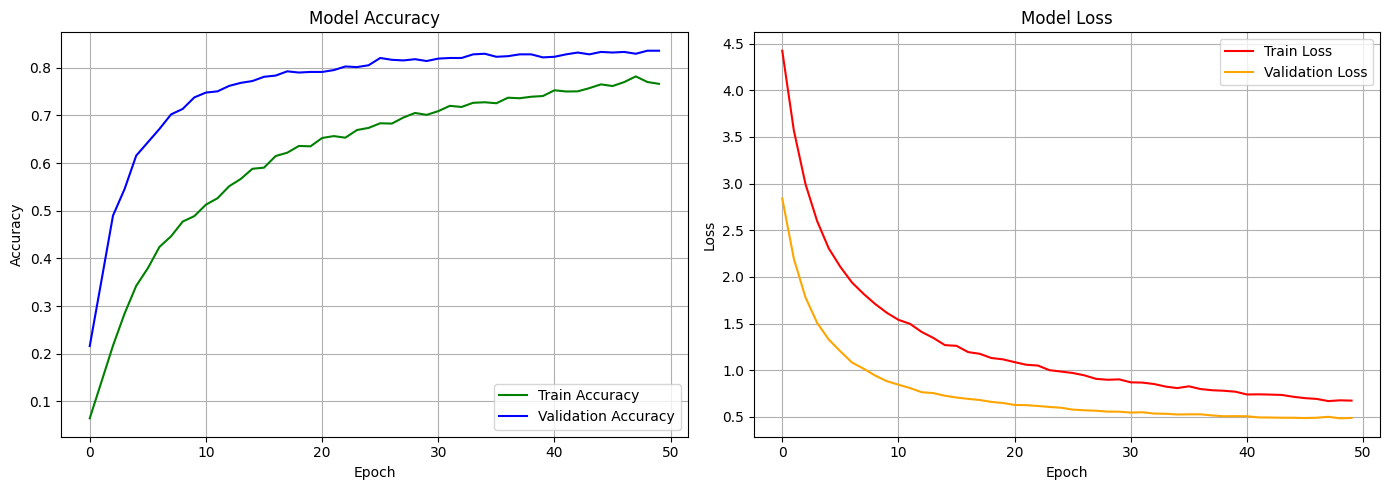

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


## Fine-tuning

In [ ]:
# Step 1: Unfreeze the last 30 layers of the base model
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Step 2: Re-compile the model with a very small learning rate
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Small LR to avoid large weight updates
    loss='categorical_crossentropy',
    metrics=['accuracy']
)




In [ ]:
# Step 3: Train the model again (fine-tuning) with class weights
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  # You can increase if training is stable
    class_weight=class_weights_dict,   # <-- هنا أضفت الـ class weights
    callbacks=[checkpoint, early_stop]
)

# Save the fine-tuned model in the new Keras format
model.save("final_finetuned_model.keras")
print(" Fine-tuned model saved as: final_finetuned_model.keras")


Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.6360 - loss: 1.1498
Epoch 1: val_loss did not improve from 0.48416
197/197 ━━━━━━━━━━━━━━━━━━━━ 99s 428ms/step - accuracy: 0.6361 - loss: 1.1495 - val_accuracy: 0.8257 - val_loss: 0.5236
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.6881 - loss: 0.9497
Epoch 2: val_loss did not improve from 0.48416
197/197 ━━━━━━━━━━━━━━━━━━━━ 78s 394ms/step - accuracy: 0.6881 - loss: 0.9495 - val_accuracy: 0.8397 - val_loss: 0.4917
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.7398 - loss: 0.7882
Epoch 3: val_loss improved from 0.48416 to 0.45396, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 392ms/step - accuracy: 0.7398 - loss: 0.7882 - val_accuracy: 0.8461 - val_loss: 0.4540
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.7576 - loss: 0.7300
Epoch 4: val_loss improved from 0.45396 to 0.41693, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 391ms/step - accuracy: 0.7575 - loss: 0.7300 - val_accuracy: 0.8601 - val_loss: 0.4169
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.7596 - loss: 0.7119
Epoch 5: val_loss improved from 0.41693 to 0.39275, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 391ms/step - accuracy: 0.7596 - loss: 0.7118 - val_accuracy: 0.8613 - val_loss: 0.3928
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.7769 - loss: 0.6751
Epoch 6: val_loss improved from 0.39275 to 0.36646, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.7769 - loss: 0.6750 - val_accuracy: 0.8677 - val_loss: 0.3665
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.7958 - loss: 0.6230
Epoch 7: val_loss improved from 0.36646 to 0.35106, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 389ms/step - accuracy: 0.7958 - loss: 0.6229 - val_accuracy: 0.8740 - val_loss: 0.3511
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.8118 - loss: 0.5565
Epoch 8: val_loss improved from 0.35106 to 0.33926, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.8118 - loss: 0.5565 - val_accuracy: 0.8791 - val_loss: 0.3393
Epoch 9/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8215 - loss: 0.5261
Epoch 9: val_loss improved from 0.33926 to 0.31715, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 390ms/step - accuracy: 0.8214 - loss: 0.5262 - val_accuracy: 0.8842 - val_loss: 0.3172
Epoch 10/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.8231 - loss: 0.5265
Epoch 10: val_loss improved from 0.31715 to 0.30561, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 390ms/step - accuracy: 0.8231 - loss: 0.5265 - val_accuracy: 0.8931 - val_loss: 0.3056
Epoch 11/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.8356 - loss: 0.5105
Epoch 11: val_loss improved from 0.30561 to 0.29701, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 79s 400ms/step - accuracy: 0.8356 - loss: 0.5105 - val_accuracy: 0.8931 - val_loss: 0.2970
Epoch 12/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.8483 - loss: 0.4549
Epoch 12: val_loss improved from 0.29701 to 0.29068, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 389ms/step - accuracy: 0.8482 - loss: 0.4550 - val_accuracy: 0.9008 - val_loss: 0.2907
Epoch 13/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.8370 - loss: 0.4745
Epoch 13: val_loss improved from 0.29068 to 0.28004, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 78s 398ms/step - accuracy: 0.8370 - loss: 0.4745 - val_accuracy: 0.9071 - val_loss: 0.2800
Epoch 14/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.8514 - loss: 0.4515
Epoch 14: val_loss improved from 0.28004 to 0.27056, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 78s 398ms/step - accuracy: 0.8514 - loss: 0.4515 - val_accuracy: 0.9084 - val_loss: 0.2706
Epoch 15/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.8527 - loss: 0.4414
Epoch 15: val_loss improved from 0.27056 to 0.26809, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 392ms/step - accuracy: 0.8527 - loss: 0.4413 - val_accuracy: 0.9071 - val_loss: 0.2681
Epoch 16/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.8517 - loss: 0.4357
Epoch 16: val_loss improved from 0.26809 to 0.25613, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 76s 388ms/step - accuracy: 0.8517 - loss: 0.4356 - val_accuracy: 0.9198 - val_loss: 0.2561
Epoch 17/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.8595 - loss: 0.4146
Epoch 17: val_loss improved from 0.25613 to 0.25162, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 390ms/step - accuracy: 0.8596 - loss: 0.4147 - val_accuracy: 0.9186 - val_loss: 0.2516
Epoch 18/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.8748 - loss: 0.3777
Epoch 18: val_loss improved from 0.25162 to 0.24490, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 391ms/step - accuracy: 0.8748 - loss: 0.3777 - val_accuracy: 0.9249 - val_loss: 0.2449
Epoch 19/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.8758 - loss: 0.3665
Epoch 19: val_loss improved from 0.24490 to 0.24213, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 392ms/step - accuracy: 0.8758 - loss: 0.3664 - val_accuracy: 0.9198 - val_loss: 0.2421
Epoch 20/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8743 - loss: 0.3903
Epoch 20: val_loss improved from 0.24213 to 0.23492, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.8743 - loss: 0.3902 - val_accuracy: 0.9237 - val_loss: 0.2349
Epoch 21/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.8774 - loss: 0.3724
Epoch 21: val_loss improved from 0.23492 to 0.22863, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 389ms/step - accuracy: 0.8774 - loss: 0.3723 - val_accuracy: 0.9237 - val_loss: 0.2286
Epoch 22/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.8873 - loss: 0.3413
Epoch 22: val_loss improved from 0.22863 to 0.22633, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 388ms/step - accuracy: 0.8873 - loss: 0.3413 - val_accuracy: 0.9275 - val_loss: 0.2263
Epoch 23/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8971 - loss: 0.3299
Epoch 23: val_loss improved from 0.22633 to 0.22139, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 391ms/step - accuracy: 0.8971 - loss: 0.3299 - val_accuracy: 0.9300 - val_loss: 0.2214
Epoch 24/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.8901 - loss: 0.3372
Epoch 24: val_loss improved from 0.22139 to 0.21544, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 76s 387ms/step - accuracy: 0.8901 - loss: 0.3372 - val_accuracy: 0.9338 - val_loss: 0.2154
Epoch 25/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8990 - loss: 0.3165
Epoch 25: val_loss improved from 0.21544 to 0.21139, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 393ms/step - accuracy: 0.8990 - loss: 0.3165 - val_accuracy: 0.9275 - val_loss: 0.2114
Epoch 26/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8980 - loss: 0.3219
Epoch 26: val_loss improved from 0.21139 to 0.20863, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 390ms/step - accuracy: 0.8980 - loss: 0.3219 - val_accuracy: 0.9300 - val_loss: 0.2086
Epoch 27/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9116 - loss: 0.2848
Epoch 27: val_loss improved from 0.20863 to 0.20450, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9115 - loss: 0.2848 - val_accuracy: 0.9288 - val_loss: 0.2045
Epoch 28/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.9093 - loss: 0.2910
Epoch 28: val_loss improved from 0.20450 to 0.19905, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 393ms/step - accuracy: 0.9093 - loss: 0.2910 - val_accuracy: 0.9326 - val_loss: 0.1990
Epoch 29/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.9071 - loss: 0.2818
Epoch 29: val_loss improved from 0.19905 to 0.19892, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 393ms/step - accuracy: 0.9071 - loss: 0.2818 - val_accuracy: 0.9288 - val_loss: 0.1989
Epoch 30/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9110 - loss: 0.2904
Epoch 30: val_loss improved from 0.19892 to 0.19742, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9110 - loss: 0.2904 - val_accuracy: 0.9288 - val_loss: 0.1974
Epoch 31/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9107 - loss: 0.2732
Epoch 31: val_loss improved from 0.19742 to 0.19400, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 391ms/step - accuracy: 0.9107 - loss: 0.2732 - val_accuracy: 0.9326 - val_loss: 0.1940
Epoch 32/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9109 - loss: 0.2697
Epoch 32: val_loss improved from 0.19400 to 0.19287, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 391ms/step - accuracy: 0.9109 - loss: 0.2697 - val_accuracy: 0.9326 - val_loss: 0.1929
Epoch 33/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9175 - loss: 0.2633
Epoch 33: val_loss improved from 0.19287 to 0.19133, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 76s 386ms/step - accuracy: 0.9175 - loss: 0.2632 - val_accuracy: 0.9313 - val_loss: 0.1913
Epoch 34/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9161 - loss: 0.2494
Epoch 34: val_loss improved from 0.19133 to 0.18538, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 392ms/step - accuracy: 0.9161 - loss: 0.2494 - val_accuracy: 0.9326 - val_loss: 0.1854
Epoch 35/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9272 - loss: 0.2388
Epoch 35: val_loss improved from 0.18538 to 0.18321, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 388ms/step - accuracy: 0.9272 - loss: 0.2388 - val_accuracy: 0.9326 - val_loss: 0.1832
Epoch 36/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9310 - loss: 0.2286
Epoch 36: val_loss improved from 0.18321 to 0.17944, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 389ms/step - accuracy: 0.9310 - loss: 0.2286 - val_accuracy: 0.9377 - val_loss: 0.1794
Epoch 37/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.9249 - loss: 0.2390
Epoch 37: val_loss improved from 0.17944 to 0.17484, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 392ms/step - accuracy: 0.9249 - loss: 0.2390 - val_accuracy: 0.9377 - val_loss: 0.1748
Epoch 38/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9259 - loss: 0.2325
Epoch 38: val_loss improved from 0.17484 to 0.17240, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 391ms/step - accuracy: 0.9259 - loss: 0.2325 - val_accuracy: 0.9351 - val_loss: 0.1724
Epoch 39/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9293 - loss: 0.2184
Epoch 39: val_loss improved from 0.17240 to 0.17033, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 390ms/step - accuracy: 0.9293 - loss: 0.2184 - val_accuracy: 0.9402 - val_loss: 0.1703
Epoch 40/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9417 - loss: 0.1998
Epoch 40: val_loss improved from 0.17033 to 0.16910, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 390ms/step - accuracy: 0.9416 - loss: 0.1998 - val_accuracy: 0.9415 - val_loss: 0.1691
Epoch 41/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9330 - loss: 0.2195
Epoch 41: val_loss improved from 0.16910 to 0.16775, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 389ms/step - accuracy: 0.9330 - loss: 0.2195 - val_accuracy: 0.9427 - val_loss: 0.1678
Epoch 42/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9398 - loss: 0.2073
Epoch 42: val_loss improved from 0.16775 to 0.16521, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 390ms/step - accuracy: 0.9398 - loss: 0.2073 - val_accuracy: 0.9415 - val_loss: 0.1652
Epoch 43/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.9387 - loss: 0.1953
Epoch 43: val_loss improved from 0.16521 to 0.16368, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 78s 394ms/step - accuracy: 0.9387 - loss: 0.1953 - val_accuracy: 0.9415 - val_loss: 0.1637
Epoch 44/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9417 - loss: 0.1866
Epoch 44: val_loss did not improve from 0.16368
197/197 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.9417 - loss: 0.1866 - val_accuracy: 0.9415 - val_loss: 0.1641
Epoch 45/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9429 - loss: 0.1864
Epoch 45: val_loss improved from 0.16368 to 0.15970, saving model to best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 391ms/step - accuracy: 0.9429 - loss: 0.1864 - val_accuracy: 0.9415 - val_loss: 0.1597
Epoch 46/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9416 - loss: 0.1979
Epoch 46: val_loss did not improve from 0.15970
197/197 ━━━━━━━━━━━━━━━━━━━━ 76s 388ms/step - accuracy: 0.9416 - loss: 0.1979 - val_accuracy: 0.9478 - val_loss: 0.1606
Epoch 47/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.9460 - loss: 0.1791
Epoch 47: val_loss did not improve from 0.15970
197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 391ms/step - accuracy: 0.9460 - loss: 0.1791 - val_accuracy: 0.9427 - val_loss: 0.1626
Epoch 48/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.9478 - loss: 0.1866
Epoch 48: val_loss did not improve from 0.15970
197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 392ms/step - accuracy: 0.9478 - loss: 0.1866 - val_accuracy: 0.9415 - val_loss: 0.1619
Epoch 48: early stopping
Restoring model weights from the end of the best epoch: 45.
 Fine-tuned model saved 

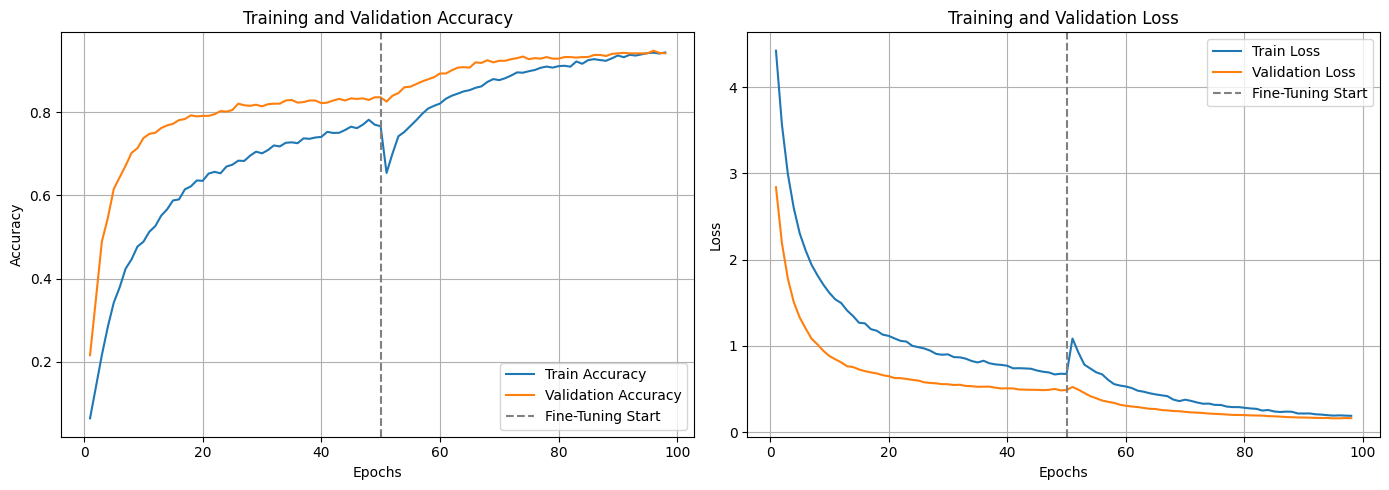

In [ ]:
import matplotlib.pyplot as plt

def plot_training_comparison(history_base, history_finetune):
    # Combine accuracy
    acc = history_base.history['accuracy'] + history_finetune.history['accuracy']
    val_acc = history_base.history['val_accuracy'] + history_finetune.history['val_accuracy']

    # Combine loss
    loss = history_base.history['loss'] + history_finetune.history['loss']
    val_loss = history_base.history['val_loss'] + history_finetune.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Accuracy plot
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.axvline(x=len(history_base.history['accuracy']), color='gray', linestyle='--', label='Fine-Tuning Start')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.axvline(x=len(history_base.history['loss']), color='gray', linestyle='--', label='Fine-Tuning Start')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function
plot_training_comparison(history, fine_tune_history)


## Evaluation

In [ ]:
from tensorflow import keras

# Load the model
model = keras.models.load_model('/content/final_finetuned_model.keras')

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.9411 - loss: 0.1760
Test Loss: 0.17704413831233978
Test Accuracy: 0.9465649127960205


In [ ]:
 #Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9482 - loss: 0.1852
Test Accuracy: 94.66%


## Testing

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# تأكد أن test_generator لا يخلط البيانات
test_generator = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

# Step 1: Predict class probabilities
y_pred_probs = model.predict(test_generator)

# Step 2: Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 3: Convert one-hot encoded y_test to class labels
y_true = np.argmax(y_test, axis=1)

# Step 4: Classification report
print(classification_report(y_true, y_pred))




 3/25 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.95      1.00      0.97        35
           2       0.96      0.96      0.96        27
           3       0.93      0.89      0.91        28
           4       0.97      1.00      0.98        29
           5       0.91      0.95      0.93        22
           6       0.88      0.92      0.90        25
           7       1.00      0.89      0.94        19
           8       0.79      0.96      0.86        23
           9       1.00      0.87      0.93        31
          10       0.94      0.77      0.85        22
          11       0.96      0.90      0.93        30
          12       0.91      0.91      0.91        35
          13       1.00      1.00      1.00        29
          14       1.00      0.93      0.96        29
          15       0.95      1.00      0.98        21
          16       0.97      0.97      0.

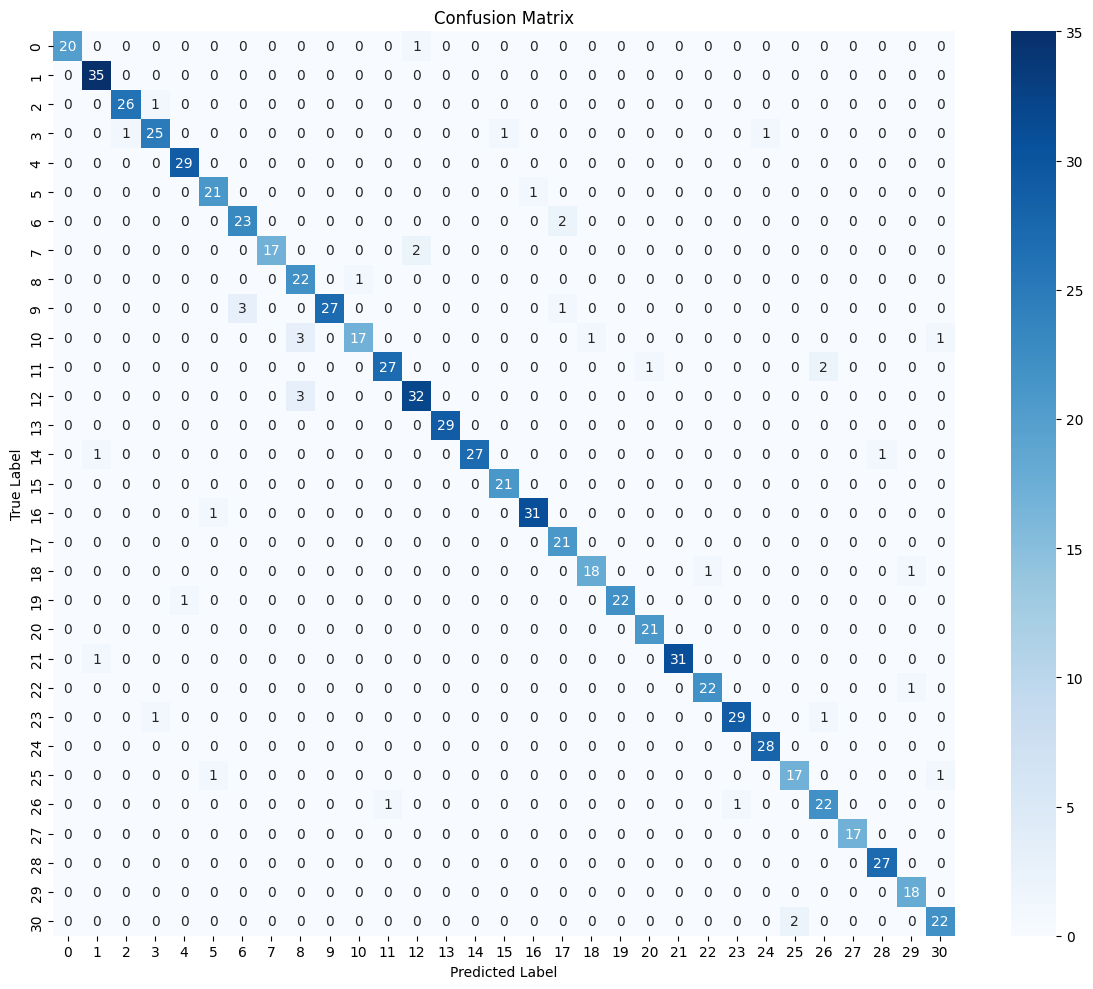

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels (you can replace with actual class names if available)
labels = sorted(set(y_true))

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()



25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


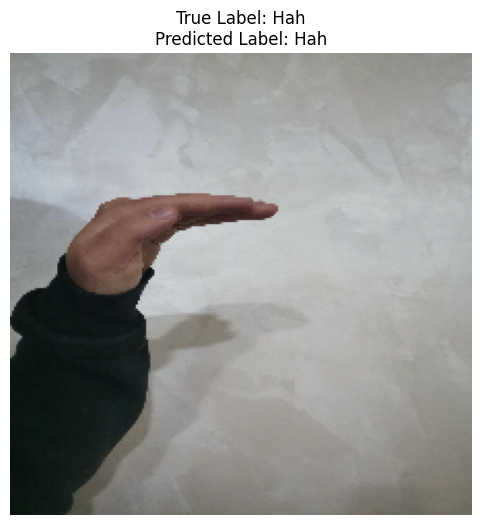

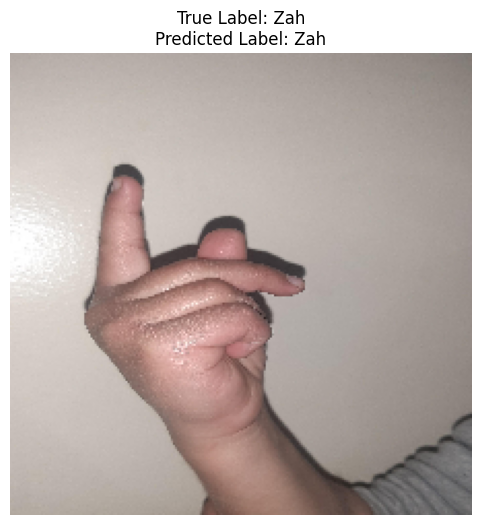

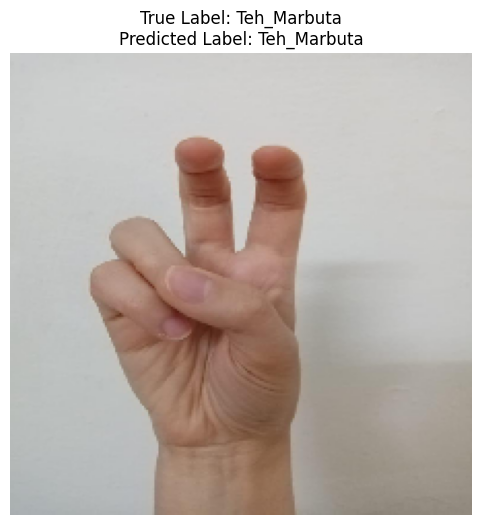

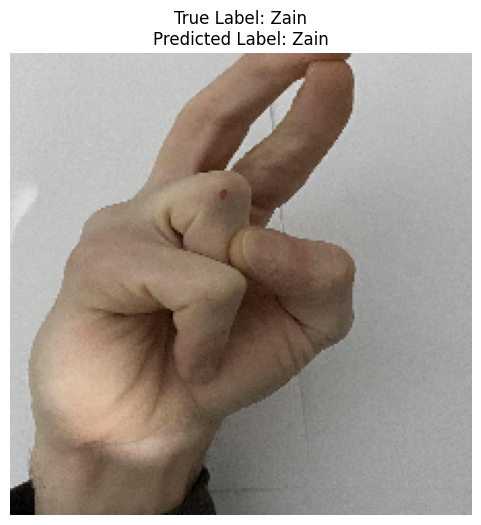

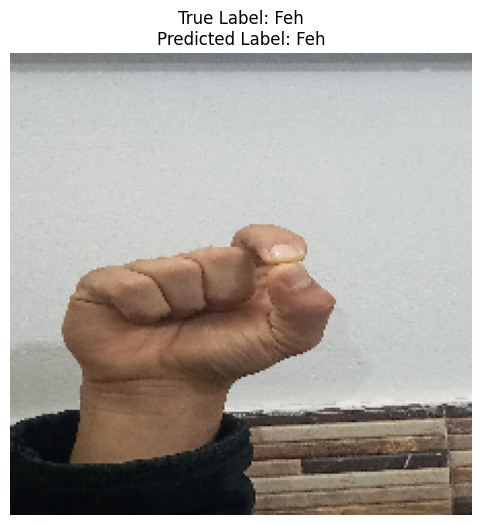

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Make predictions on test data
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

def plot_image(img_array, true_label, pred_label):
    plt.figure(figsize=(6, 6))
    if img_array.dtype == np.float32 or img_array.dtype == np.float64:
        img_array = img_array / 255.0  # تحويل القيم من [0, 255] إلى [0, 1]
    plt.imshow(img_array)
    plt.title(f"True Label: {true_label}\nPredicted Label: {pred_label}")
    plt.axis('off')
    plt.show()

# Plot a few test images with actual and predicted class names
num_images_to_plot = 5
for i in range(num_images_to_plot):
    # Get the image and its true label
    img = X_test[i]
    true_label = label_encoder.inverse_transform([y_true_classes[i]])[0]
    # Get the predicted label
    pred_label = label_encoder.inverse_transform([y_pred_classes[i]])[0]

    # Plot the image with title showing true and predicted labels
    plot_image(img, true_label, pred_label)